# Imports

In [1]:
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import pickle
import numpy as np
from PIL import Image, ImageOps
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from scipy.spatial import distance
from sklearn.metrics.pairwise import manhattan_distances

# Loading Datasets

In [2]:
# save and load data from pickel
def save_obj(obj, name ):
    with open(name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
def load_obj_real(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Generated Dataset

### Load Preporcessed Dataset

In [3]:
# loading images
images_real = load_obj_real("/work/kabaeuer/AA_Experiment/Analysis/ImageNette/imagenette_images")
images_trans_pixel = load_obj_real("/work/kabaeuer/logs/imagenette_32_2022_03_04_15_56_38/Samples/images")
images_trans_bil = load_obj_real("/work/kabaeuer/logs/imagenette_32_bil_2022_03_19_19_02_33/Samples/images1")
images_trans_bic = load_obj_real("/work/kabaeuer/logs/imagenette_32_bic_2022_03_20_17_08_00/Samples/images1")
images_trans_relu = load_obj_real("/work/kabaeuer/logs/imagenette_32_RELU_2022_04_05_11_22_05/Samples/images1")
images_trans_filt = load_obj_real("/work/kabaeuer/logs/imagenette_32_filtered/Samples/images")
images_trans_highdim = load_obj_real("/work/kabaeuer/logs/imagenette_32_highdim/Load_mannheim/images100000")
images_trans_class = load_obj_real("/work/kabaeuer/logs/imagenette_32_class/imagenette_images_sorted_100000")
images_dc_bil = load_obj_real("/work/kabaeuer/AA_Experiment/bilinear_DC_n/log/all_images")
images_sn_bic = load_obj_real("/work/kabaeuer/AA_Experiment/bicubic_SN/log/example/all_images")
images_sn_bil = load_obj_real("/work/kabaeuer/AA_Experiment/bilinear_SN3/log/example/all_images")
images_sn_bil_high = load_obj_real("/work/kabaeuer/AA_Experiment/bilinear_SN_HighDim_32/log/example/all_images")
images_sn_bil_relFil = load_obj_real("/work/kabaeuer/AA_Experiment/bilinear_SN_32_filtered_relu/log/example/all_images")
images_sn_pix = load_obj_real("/work/kabaeuer/AA_Experiment/pixel_SN_n/log/example/all_images")
images_sn_gelu = load_obj_real("/work/kabaeuer/AA_Experiment/bilinear_SN_gelu_32/log/example/all_images")
images_sn_layer = load_obj_real("/work/kabaeuer/AA_Experiment/bilinear_SN_Layer_32/log/example/all_images")
images_best = load_obj_real("/work/kabaeuer/logs/best_imagenette/nette/images1590")

Real Images: 13260
Trans Images: 50000
Trans_bil Images: 50000
Trans_bic Images: 50000
Trans_relu Images: 50000
Trans_filt Images: 50000
Trans_highDim Images: 50000
Trans_class Images: 50000
DC_bil Images: 39933
SN_bil Images: 39936
SN_bic Images: 39936
SN_high Images: 39936
SN_relFil Images: 39936
SN_Pix Images: 39936
SN_Gelu Images: 39936
SN_Layer Images: 39936


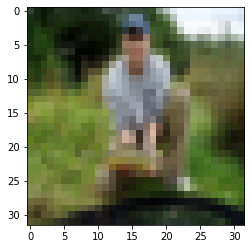

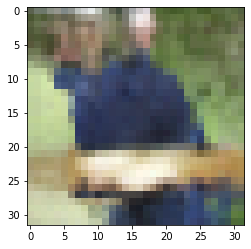

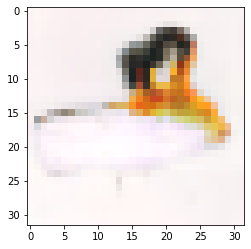

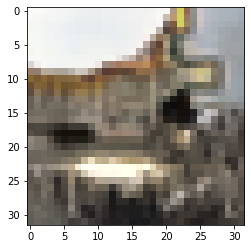

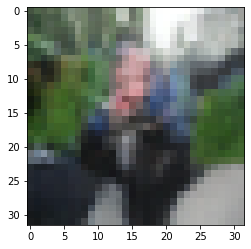

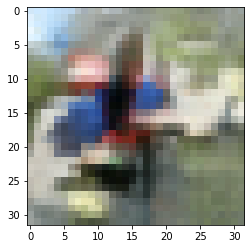

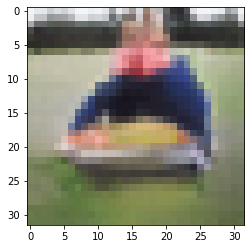

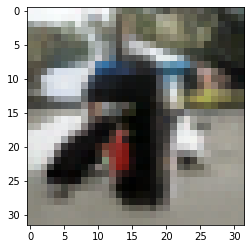

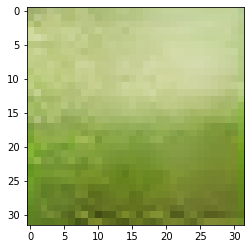

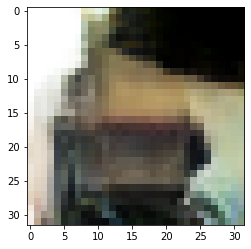

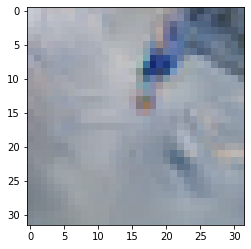

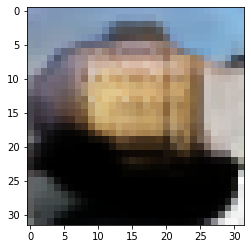

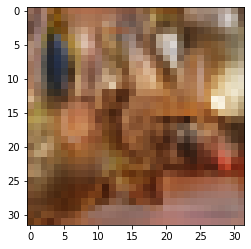

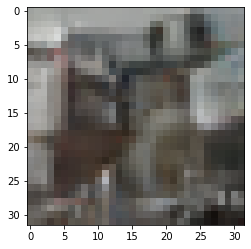

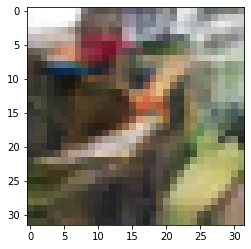

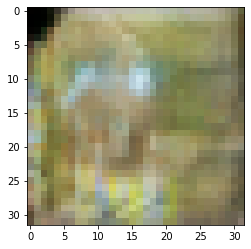

In [4]:
# Example image
print("Real Images:", len(images_real))
print("Trans Images:", len(images_trans_pixel))
print("Trans_bil Images:", len(images_trans_bil))
print("Trans_bic Images:", len(images_trans_bic))
print("Trans_relu Images:", len(images_trans_relu))
print("Trans_filt Images:", len(images_trans_filt))
print("Trans_highDim Images:", len(images_trans_highdim))
print("Trans_class Images:", len(images_trans_class))
print("DC_bil Images:", len(images_dc_bil))
print("SN_bil Images:", len(images_sn_bic))
print("SN_bic Images:", len(images_sn_bil))
print("SN_high Images:", len(images_sn_bil_high))
print("SN_relFil Images:", len(images_sn_bil_relFil))
print("SN_Pix Images:", len(images_sn_pix))
print("SN_Gelu Images:", len(images_sn_gelu))
print("SN_Layer Images:", len(images_sn_layer))
imgplot = plt.imshow(images_real[3])
plt.show()
imgplot = plt.imshow(images_trans_pixel[3])
plt.show()
imgplot = plt.imshow(images_trans_bil[12])
plt.show()
imgplot = plt.imshow(images_trans_bic[12])
plt.show()
imgplot = plt.imshow(images_trans_relu[12])
plt.show()
imgplot = plt.imshow(images_trans_filt[12])
plt.show()
imgplot = plt.imshow(images_trans_highdim[12])
plt.show()
imgplot = plt.imshow(images_trans_class[12])
plt.show()
imgplot = plt.imshow(images_dc_bil[3])
plt.show()
imgplot = plt.imshow(images_sn_bic[3])
plt.show()
imgplot = plt.imshow(images_sn_bil[2])
plt.show()
imgplot = plt.imshow(images_sn_bil_high[5])
plt.show()
imgplot = plt.imshow(images_sn_bil_relFil[6])
plt.show()
imgplot = plt.imshow(images_sn_pix[100])
plt.show()
imgplot = plt.imshow(images_sn_gelu[100])
plt.show()
imgplot = plt.imshow(images_sn_layer[100])
plt.show()

## Real Images

# Analyzing Images

## Creating FFT

In [5]:
def fft(img):
    img = np.array(img)
    img_g = 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2]
    #plt.imshow(img_g,cmap='gray')
    fft = np.fft.fft2(img_g)
    fshift = np.fft.fftshift(fft)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum

# Create Informations
def create_informations(images, normalized= False):
    two_dim = fft(images[0])
    if normalized:
        two_dim = two_dim /two_dim.max()
    m,n = two_dim.shape
    zero_axis = np.sum(two_dim, axis=0)/m
    one_axis = np.sum(two_dim, axis=1)/n
    min_zero_axis = zero_axis
    max_zero_axis = zero_axis
    min_one_axis = one_axis
    max_one_axis = one_axis
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals /fft_vals.max()
        two_dim = two_dim + fft_vals
        cur_zero_axis = np.sum(fft_vals, axis=0)/m
        zero_axis = zero_axis + cur_zero_axis
        cur_one_axis = np.sum(fft_vals, axis=1)/n
        one_axis = one_axis + cur_one_axis
        min_zero_axis = np.minimum(min_zero_axis, cur_zero_axis)
        max_zero_axis = np.maximum(max_zero_axis, cur_zero_axis)
        min_one_axis = np.minimum(min_one_axis, cur_one_axis)
        max_one_axis = np.maximum(max_one_axis, cur_one_axis)
    two_dim = two_dim/len(images)
    zero_axis = zero_axis/ len(images)
    one_axis = one_axis/ len(images)
    std_zero_axis = ((np.sum(two_dim, axis=0)/m)-zero_axis)**2
    std_one_axis = ((np.sum(two_dim, axis=1)/m)-one_axis)**2
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals/fft_vals.max()
        std_zero_axis = std_zero_axis + ((np.sum(fft_vals, axis=0)/m)-zero_axis)**2
        std_one_axis = std_one_axis + ((np.sum(fft_vals, axis=1)/m)-zero_axis)**2
    std_zero_axis = np.sqrt(std_zero_axis/len(images))
    std_one_axis = np.sqrt(std_one_axis/len(images))
    return two_dim, zero_axis, one_axis, m, n, min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis

# Create Overview Plot
def create_overview_plot(two_dim, zero_axis, one_axis, m, n,min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis, max_min = True):
    # Create
    fig = plt.figure(figsize=(17, 17)) 
    ax1 = plt.subplot2grid((17, 17), (1, 1), colspan=8,rowspan=8)
    ax1.plot(zero_axis)
    ax1.fill_between(range(m), zero_axis + std_zero_axis, zero_axis -std_zero_axis,facecolor='lightskyblue', alpha=0.3)
    ax2 = plt.subplot2grid((17, 17), (9, 1), colspan=8,rowspan=8)
    im3 = ax2.imshow(two_dim)
    ax3 = plt.subplot2grid((17, 17), (9, 9), colspan=8,rowspan=8)
    ax3.plot(one_axis,range(n))
    ax3.fill_betweenx(range(n),one_axis+std_one_axis, one_axis-std_one_axis, facecolor='lightskyblue', alpha=0.3)
    ax4 = plt.subplot2grid((17,17),(9,0),colspan=1,rowspan=8)

    fig.colorbar(im3, ax=ax4,fraction=0.5,ticklocation='left')
    box2 = ax2.get_position()
    box2 = [box2.x0 + 0.01, box2.y0,  box2.width+0.002, box2.height] 
    ax2.set_position(box2)
    box1 = ax1.get_position()
    box1 = [box1.x0, box1.y0-0.007,  box1.width +0.022, box1.height-0.007] 
    ax1.set_position(box1)
    box3 = ax3.get_position()
    box3 = [box3.x0, box3.y0-0.016,  box3.width, box3.height+0.032] 
    ax3.set_position(box3)
    if max_min:
        ax3.plot(min_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax3.plot(max_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),min_zero_axis, linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),max_zero_axis, linestyle='dashed', color='lightskyblue')
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax4.axis('off')
    ax2.axis('off')
    plt.show()
    
def create_comparison_plot(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot(two_dim_1-two_dim_2,zero_axis_1-zero_axis_2,one_axis_1-one_axis_2,m_1,n_1,0,0,0,0,0,0,False)
    else:
        print("The dimensions are not the same!")

def create_comparison_plot_rel(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot((two_dim_1-two_dim_2)/two_dim_1,(zero_axis_1-zero_axis_2)/zero_axis_1,(one_axis_1-one_axis_2)/one_axis_1,m_1,n_1,0,0,0,0,0,0, False)
    else:
        print("The dimensions are not the same!")

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def calc_statics(images_generated, data_names):
    minner = len(images_real)
    for datas in images_generated:
        minner = min(minner, len(datas))
    for i in range(len(images_generated)):
        print(data_names[i] + ":")
        two_dim_t, zero_axis_t, one_axis_t, m_t, n_t,min_zero_axis_t,max_zero_axis_t, min_one_axis_t, max_one_axis_t, std_zero_axis_t, std_one_axis_t = create_informations(images_generated[i][0:minner])    
        print("KL-Divergence (column): ",kl_divergence(zero_axis_r,zero_axis_t))
        print("KL-Divergence (row): ", kl_divergence(one_axis_r,one_axis_t))
        print("KL-Divergence (both): ", (abs(kl_divergence(one_axis_r,one_axis_t))+abs(kl_divergence(zero_axis_r,zero_axis_t)))/2)
        print()
        print("Manhattan distance (column): ", manhattan_distances([zero_axis_r],[zero_axis_t])[0][0])
        print("Manhattan distance (row): ", manhattan_distances([one_axis_r],[one_axis_t])[0][0])
        print("Manhattan distance (both): ", (manhattan_distances([one_axis_r],[one_axis_t])[0][0]+ manhattan_distances([zero_axis_r],[zero_axis_t])[0][0])/2)
        print()
        print("Euclidean distance (column): ", np.linalg.norm(zero_axis_r-zero_axis_t))
        print("Euclidean distance (row): ", np.linalg.norm(one_axis_r-one_axis_t))
        print("Euclidean distance (both): ", (np.linalg.norm(one_axis_r-one_axis_t)+np.linalg.norm(zero_axis_r-zero_axis_t))/2)
        print()
        print()

def calc_statics_norm(images_generated, data_names):
    minner = len(images_real)
    for datas in images_generated:
        minner = min(minner, len(datas))
    for i in range(len(images_generated)):
        print(data_names[i] + ":")
        two_dim_t, zero_axis_t, one_axis_t, m_t, n_t,min_zero_axis_t,max_zero_axis_t, min_one_axis_t, max_one_axis_t, std_zero_axis_t, std_one_axis_t = create_informations(images_generated[i][0:minner])    
        print("KL-Divergence (column): ",kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_t/zero_axis_t.max()))
        print("KL-Divergence (row): ", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_t/one_axis_t.max()))
        print("KL-Divergence (both): ", (abs(kl_divergence(one_axis_r/one_axis_r.max(),one_axis_t/one_axis_t.max()))+abs(kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_t/zero_axis_t.max())))/2)
        print()
        print("Manhattan distance (column): ", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_t/zero_axis_t.max()])[0][0])
        print("Manhattan distance (row): ", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_t/one_axis_t.max()])[0][0])
        print("Manhattan distance (both): ", (manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_t/one_axis_t.max()])[0][0]+manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_t/zero_axis_t.max()])[0][0])/2)
        print()
        print("Euclidean distance (column): ", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_t/zero_axis_t.max()))
        print("Euclidean distance (row): ", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_t/one_axis_t.max()))
        print("Euclidean distance (row): ", (np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_t/one_axis_t.max())+np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_t/zero_axis_t.max()))/2)
        print()
        print()

In [6]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
two_dim_t, zero_axis_t, one_axis_t, m_t, n_t,min_zero_axis_t,max_zero_axis_t, min_one_axis_t, max_one_axis_t, std_zero_axis_t, std_one_axis_t = create_informations(images_trans_pixel)
two_dim_t_b, zero_axis_t_b, one_axis_t_b, m_t_b, n_t_b, min_zero_axis_t_b, max_zero_axis_t_b, min_one_axis_t_b, max_one_axis_t_b, std_zero_axis_t_b, std_one_axis_t_b = create_informations(images_trans_bil)
two_dim_t_bic, zero_axis_t_bic, one_axis_t_bic, m_t_bic, n_t_bic, min_zero_axis_t_bic, max_zero_axis_t_bic, min_one_axis_t_bic, max_one_axis_t_bic, std_zero_axis_t_bic, std_one_axis_t_bic = create_informations(images_trans_bic)
two_dim_t_relu, zero_axis_t_relu, one_axis_t_relu, m_t_relu, n_t_relu, min_zero_axis_t_relu, max_zero_axis_t_relu, min_one_axis_t_relu, max_one_axis_t_relu, std_zero_axis_t_relu, std_one_axis_t_relu = create_informations(images_trans_relu)
two_dim_t_filt, zero_axis_t_filt, one_axis_t_filt, m_t_filt, n_t_filt, min_zero_axis_t_filt, max_zero_axis_t_filt, min_one_axis_t_filt, max_one_axis_t_filt, std_zero_axis_t_filt, std_one_axis_t_filt = create_informations(images_trans_filt)
two_dim_t_hd, zero_axis_t_hd, one_axis_t_hd, m_t_hd, n_t_hd, min_zero_axis_t_hd, max_zero_axis_t_hd, min_one_axis_t_hd, max_one_axis_t_hd, std_zero_axis_t_hd, std_one_axis_t_hd = create_informations(images_trans_highdim)
two_dim_t_c, zero_axis_t_c, one_axis_t_c, m_t_c, n_t_c, min_zero_axis_t_c, max_zero_axis_t_c, min_one_axis_t_c, max_one_axis_t_c, std_zero_axis_t_c, std_one_axis_t_c = create_informations(images_trans_class)
two_dim_dcbil, zero_axis_dcbil, one_axis_dcbil, m_dcbil, n_dcbil,min_zero_axis_dcbil,max_zero_axis_dcbil, min_one_axis_dcbil, max_one_axis_dcbil, std_zero_axis_dcbil, std_one_axis_dcbil = create_informations(images_dc_bil)
two_dim_snbic, zero_axis_snbic, one_axis_snbic, m_snbic, n_abil,min_zero_axis_snbic,max_zero_axis_snbic, min_one_axis_snbic, max_one_axis_snbic, std_zero_axis_snbic, std_one_axis_snbic = create_informations(images_sn_bic)
two_dim_snbil, zero_axis_snbil, one_axis_snbil, m_snbil, n_snbil,min_zero_axis_snbil,max_zero_axis_snbil, min_one_axis_snbil, max_one_axis_snbil, std_zero_axis_snbil, std_one_axis_snbil = create_informations(images_sn_bil)
two_dim_snh, zero_axis_snh, one_axis_snh, m_snh, n_snh,min_zero_axis_snh,max_zero_axis_snh, min_one_axis_snh, max_one_axis_snh, std_zero_axis_snh, std_one_axis_snh = create_informations(images_sn_bil_high)
two_dim_snr, zero_axis_snr, one_axis_snr, m_snr, n_snr,min_zero_axis_snr,max_zero_axis_snr, min_one_axis_snr, max_one_axis_snr, std_zero_axis_snr, std_one_axis_snr = create_informations(images_sn_bil_relFil)
two_dim_snpi, zero_axis_snpi, one_axis_snpi, m_snpi, n_snpi,min_zero_axis_snpi,max_zero_axis_snpi, min_one_axis_snpi, max_one_axis_snpi, std_zero_axis_snpi, std_one_axis_snpi = create_informations(images_sn_pix)
two_dim_sngelu, zero_axis_sngelu, one_axis_sngelu, m_sngelu, n_sngelu,min_zero_axis_sngelu,max_zero_axis_sngelu, min_one_axis_sngelu, max_one_axis_sngelu, std_zero_axis_sngelu, std_one_axis_sngelu = create_informations(images_sn_gelu)
two_dim_snl, zero_axis_snl, one_axis_snl, m_snl, n_snl,min_zero_axis_snl,max_zero_axis_snl, min_one_axis_snl, max_one_axis_snl, std_zero_axis_snl, std_one_axis_snl = create_informations(images_sn_layer)
two_dim_b, zero_axis_b, one_axis_b, m_b, n_b,min_zero_axis_b,max_zero_axis_b, min_one_axis_b, max_one_axis_b, std_zero_axis_b, std_one_axis_b = create_informations(images_best)


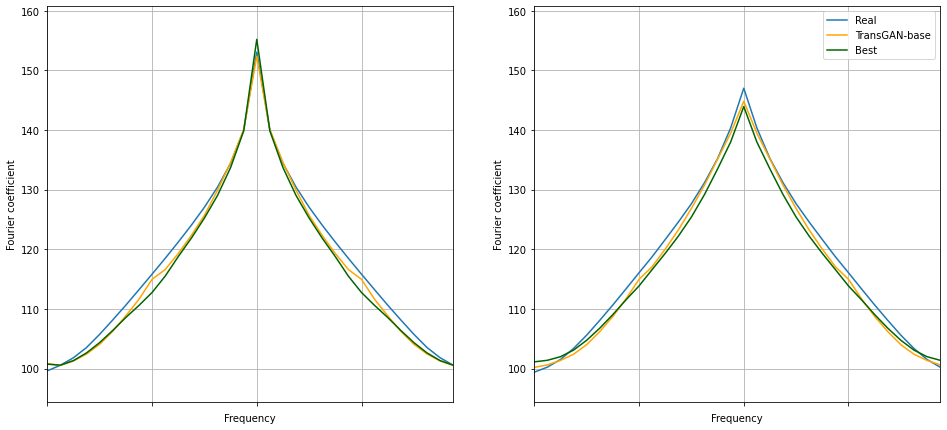

In [11]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real')
ax1.plot(range(len(zero_axis_t)),zero_axis_t, label='TransGAN-base', color="orange")
#ax1.plot(range(len(zero_axis_t_b)),zero_axis_t_b, label='TransGAN-bilinear', color="silver")
#ax1.plot(range(len(zero_axis_t_bic)),zero_axis_t_bic, label='TransGAN-bicubic', color="gold")
#ax1.plot(range(len(zero_axis_t_relu)),zero_axis_t_relu, label='TransGAN-relu', color="tan")
#ax1.plot(range(len(zero_axis_t_filt)),zero_axis_t_filt, label='TransGAN-filter', color="greenyellow")
#ax1.plot(range(len(zero_axis_t_hd)),zero_axis_t_hd, label='TransGAN-highDim', color="crimson")
#ax1.plot(range(len(zero_axis_t_c)),zero_axis_t_c, label='TransGAN-class', color="black")
#ax1.plot(range(len(zero_axis_dcbil)),zero_axis_dcbil, label='DC_Bil')
#ax1.plot(range(len(zero_axis_snbic)),zero_axis_snbic, label='SNGAN-bicubic', color="gold")
#ax1.plot(range(len(zero_axis_snbil)),zero_axis_snbil, label='SNGAN-base', color="gray")
#ax1.plot(range(len(zero_axis_snh)),zero_axis_snh, label='SNGAN-highDim', color="crimson")
#ax1.plot(range(len(zero_axis_snr)),zero_axis_snr, label='SNGAN-filter', color="greenyellow")
#ax1.plot(range(len(zero_axis_snpi)),zero_axis_snpi, label='SNGAN-pixel', color="darkorange")
#ax1.plot(range(len(zero_axis_sngelu)),zero_axis_sngelu, label='SNGAN-GELU', color = "plum")
#ax1.plot(range(len(zero_axis_snl)),zero_axis_snl, label='SNGAN-layer', color="indigo")
ax1.plot(range(len(zero_axis_b)),zero_axis_b, label='Best', color="darkgreen")

ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real')
ax2.plot(range(len(one_axis_t)),one_axis_t, label='TransGAN-base', color="orange")
#ax2.plot(range(len(one_axis_t_b)),one_axis_t_b, label='TransGAN-bilinear', color="silver")
#ax2.plot(range(len(one_axis_t_bic)),one_axis_t_bic, label='TransGAN-bicubic', color="gold")
#ax2.plot(range(len(one_axis_t_relu)),one_axis_t_relu, label='TransGAN-relu', color="tan")
#ax2.plot(range(len(one_axis_t_filt)),one_axis_t_filt, label='TransGAN-filter', color="greenyellow")
#ax2.plot(range(len(one_axis_t_hd)),one_axis_t_hd, label='TransGAN-highDim',color="crimson")
#ax2.plot(range(len(one_axis_t_c)),one_axis_t_c, label='TransGAN-class', color="black")
#ax2.plot(range(len(one_axis_dcbil)),one_axis_dcbil, label='DC_Bil')
#ax2.plot(range(len(one_axis_snbic)),one_axis_snbic, label='SNGAN-bicubic', color="gold")
#ax2.plot(range(len(one_axis_snbil)),one_axis_snbil, label='SNGAN-base', color="gray")
#ax2.plot(range(len(one_axis_snh)),one_axis_snh, label='SNGAN-highDim', color="crimson")
#ax2.plot(range(len(one_axis_snr)),one_axis_snr, label='SNGAN-filter', color="greenyellow")
#ax2.plot(range(len(one_axis_snpi)),one_axis_snpi, label='SNGAN-pixel', color="darkorange")
#ax2.plot(range(len(one_axis_sngelu)),one_axis_sngelu, label='SNGAN-gelu', color = "plum")
#ax2.plot(range(len(one_axis_snl)),one_axis_snl, label='SNGAN-layer', color="indigo")
ax2.plot(range(len(one_axis_b)),one_axis_b, label='Best', color="darkgreen")

ax1.grid()
ax2.grid()

ymin = min(min(zero_axis_r),min(zero_axis_t),min(one_axis_r),min(one_axis_t))
ymax = max(max(zero_axis_r),max(zero_axis_t),max(one_axis_r),max(one_axis_t))
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Fourier coefficient')
ax2.set_ylabel('Fourier coefficient')
ax2.set_xlabel('Frequency')
ax1.set_xticklabels([])
ax2.set_xticklabels([])
#leg = ax1.legend()
leg = ax2.legend()
#fig.suptitle("Comparison between Real, TransGAN (Pixel, Bilinear, Bicubic), SNGAN (Pixel, Bilinear, Bicubic, Filtered, HighDim) - left: colomn wise right: row-wise", fontsize=20)

In [8]:
calc_statics([images_trans_pixel, images_trans_bil,images_trans_bic, images_trans_relu, images_trans_filt, images_trans_highdim, images_trans_class, images_dc_bil,images_sn_bic,images_sn_bil,images_sn_bil_high,images_sn_bil_relFil,images_sn_pix,images_sn_gelu,images_sn_layer, images_best],
             ["TransGAN", "TransGAN_bil","TransGAN_bic", "TransGAN_relu", "TransGAN_filt", "TransGAN_HD", "TransGAN_Class","DCGAN_bil", "SN_bic", "SN_bil", "SN_highDim", "SN_relFil", "SN_Pix", "SN_Gelu", "SN_Layer", "Best"])

TransGAN:
KL-Divergence (column):  31.111600426035686
KL-Divergence (row):  31.096030599483896
KL-Divergence (both):  31.10381551275979

Manhattan distance (column):  34.850745878358595
Manhattan distance (row):  34.28079079433891
Manhattan distance (both):  34.565768336348754

Euclidean distance (column):  7.169559299452232
Euclidean distance (row):  6.981891206134941
Euclidean distance (both):  7.075725252793587


TransGAN_bil:
KL-Divergence (column):  7.347742053234602
KL-Divergence (row):  7.296710154751715
KL-Divergence (both):  7.322226103993158

Manhattan distance (column):  22.25551373709679
Manhattan distance (row):  16.01295324510835
Manhattan distance (both):  19.13423349110257

Euclidean distance (column):  4.622736842146579
Euclidean distance (row):  3.1490127834460293
Euclidean distance (both):  3.8858748127963043


TransGAN_bic:
KL-Divergence (column):  -171.3931332950665
KL-Divergence (row):  -171.18664117703156
KL-Divergence (both):  171.28988723604903

Manhattan dista

## Normalized

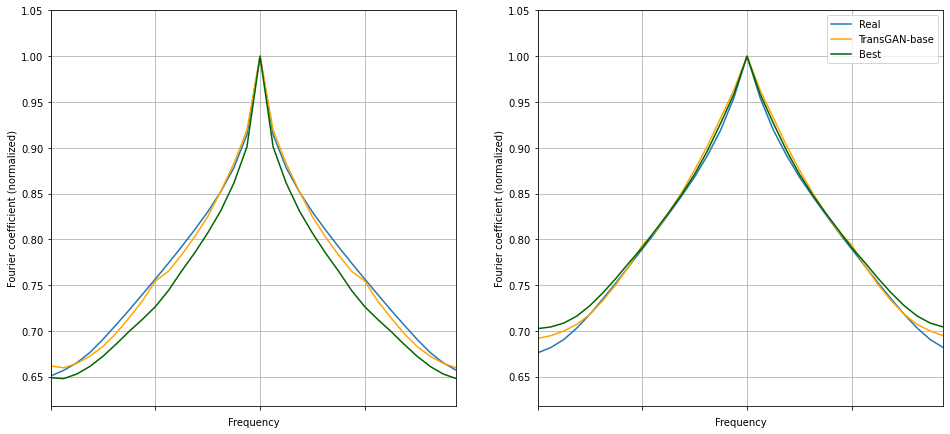

In [12]:

fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r/zero_axis_r.max(), label='Real')
ax1.plot(range(len(zero_axis_t)),zero_axis_t/zero_axis_t.max(), label='TransGAN-base', color="orange")
#ax1.plot(range(len(zero_axis_t_b)),zero_axis_t_b/zero_axis_t_b.max(), label='TransGAN-bilinear', color="silver")
#ax1.plot(range(len(zero_axis_t_bic)),zero_axis_t_bic/zero_axis_t_bic.max(), label='TransGAN-bicubic', color="gold")
#ax1.plot(range(len(zero_axis_t_relu)),zero_axis_t_relu/zero_axis_t_relu.max(), label='TransGAN-relu', color="tan")
#ax1.plot(range(len(zero_axis_t_filt)),zero_axis_t_filt/zero_axis_t_filt.max(), label='TransGAN-filter', color="greenyellow")
#ax1.plot(range(len(zero_axis_t_hd)),zero_axis_t_hd/zero_axis_t_hd.max(), label='TransGAN-highDim', color="crimson")
#ax1.plot(range(len(zero_axis_t_c)),zero_axis_t_c/zero_axis_t_c.max(), label='TransGAN-class', color="black")
#ax1.plot(range(len(zero_axis_dcbil)),zero_axis_dcbil/zero_axis_dcbil.max(), label='DC_Bil')
#ax1.plot(range(len(zero_axis_snbic)),zero_axis_snbic/zero_axis_snbic.max(), label='SNGAN-bicubic', color="gold")
#ax1.plot(range(len(zero_axis_snbil)),zero_axis_snbil/zero_axis_snbil.max(), label='SNGAN-base', color="gray")
#ax1.plot(range(len(zero_axis_snh)),zero_axis_snh/zero_axis_snh.max(), label='SNGAN-highDim', color="crimson")
#ax1.plot(range(len(zero_axis_snr)),zero_axis_snr/zero_axis_snr.max(), label='SNGAN-filter', color="greenyellow")
#ax1.plot(range(len(zero_axis_snpi)),zero_axis_snpi/zero_axis_snpi.max(), label='SN_Pix', color="darkorange")
#ax1.plot(range(len(zero_axis_sngelu)),zero_axis_sngelu/zero_axis_sngelu.max(), label='SNGAN-gelu', color="plum")
#ax1.plot(range(len(zero_axis_snl)),zero_axis_snl/zero_axis_snl.max(), label='SN_Layer', color="indigo")
ax1.plot(range(len(zero_axis_b)),zero_axis_b/zero_axis_b.max(), label='Best', color="darkgreen")

ax2.plot(range(len(one_axis_r)),one_axis_r/one_axis_r.max(), label='Real')
ax2.plot(range(len(one_axis_t)),one_axis_t/one_axis_t.max(), label='TransGAN-base', color="orange")
#ax2.plot(range(len(one_axis_t_b)),one_axis_t_b/one_axis_t_b.max(), label='TransGAN-bilinear', color="silver")
#ax2.plot(range(len(one_axis_t_bic)),one_axis_t_bic/one_axis_t_bic.max(), label='TransGAN-bicubic', color="gold")
#ax2.plot(range(len(one_axis_t_relu)),one_axis_t_relu/one_axis_t_relu.max(), label='TransGAN-relu', color="tan")
#ax2.plot(range(len(one_axis_t_filt)),one_axis_t_filt/one_axis_t_filt.max(), label='TransGAN-filter', color="greenyellow")
#ax2.plot(range(len(one_axis_t_hd)),one_axis_t_hd/one_axis_t_hd.max(), label='TransGAN-highDim', color="crimson")
#ax2.plot(range(len(one_axis_t_c)),one_axis_t_c/one_axis_t_c.max(), label='TransGAN-class', color="black")
#ax2.plot(range(len(one_axis_dcbil)),one_axis_dcbil/one_axis_dcbil.max(), label='DC_Bil')
#ax2.plot(range(len(one_axis_snbic)),one_axis_snbic/one_axis_snbic.max(), label='SNGAN-bicubic', color="gold")
#ax2.plot(range(len(one_axis_snbil)),one_axis_snbil/one_axis_snbil.max(), label='SNGAN-base', color="gray")
#ax2.plot(range(len(one_axis_snh)),one_axis_snh/one_axis_snh.max(), label='SNGAN-highDim', color="crimson")
#ax2.plot(range(len(one_axis_snr)),one_axis_snr/one_axis_snr.max(), label='SNGAN-filter',color="greenyellow")
#ax2.plot(range(len(one_axis_snpi)),one_axis_snpi/one_axis_snpi.max(), label='SNGAN-pixel', color="darkorange")
#ax2.plot(range(len(one_axis_sngelu)),one_axis_sngelu/one_axis_sngelu.max(), label='SNGAN-gelu', color="plum")
#ax2.plot(range(len(one_axis_snl)),one_axis_snl/one_axis_snl.max(), label='SN_Layer', color="indigo")
ax2.plot(range(len(one_axis_b)),one_axis_b/one_axis_b.max(), label='Best', color="darkgreen")

ax1.grid()
ax2.grid()
ymin = min(min(zero_axis_r/zero_axis_r.max()),min(zero_axis_t/zero_axis_t.max()),min(one_axis_r/one_axis_r.max()),min(one_axis_t/one_axis_t.max()))
ymax = 1
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Fourier coefficient (normalized)')
ax2.set_ylabel('Fourier coefficient (normalized)')
ax2.set_xlabel('Frequency')
ax1.set_xticklabels([])
ax2.set_xticklabels([])

#leg = ax1.legend()
leg = ax2.legend()
#fig.suptitle("Comparison between Real, TransGAN (upsampling) - Normalized - left: colomn wise right: row-wise", fontsize=20)

In [10]:
calc_statics_norm([images_real, images_trans_pixel, images_trans_bil, images_trans_bic, images_trans_relu, images_trans_filt, images_trans_highdim, images_trans_class, images_dc_bil,images_sn_bic,images_sn_bil,images_sn_bil_high,images_sn_bil_relFil,images_sn_pix, images_sn_gelu, images_sn_layer, images_best],
             ["Real","TransGAN", "TransGAN_bil","TransGAN_bic", "TransGAN_relu", "TransGAN_filt", "TransGAN_HD", "TransGAN_Class", "DCGAN_bil", "SN_bic", "SN_bil", "SN_highDim", "SN_relFil", "SN_Pix", "SN_Gelu", "SN_Layer", "Best"])

Real:
KL-Divergence (column):  0.0
KL-Divergence (row):  0.0
KL-Divergence (both):  0.0

Manhattan distance (column):  0.0
Manhattan distance (row):  0.0
Manhattan distance (both):  0.0

Euclidean distance (column):  0.0
Euclidean distance (row):  0.0
Euclidean distance (row):  0.0


TransGAN:
KL-Divergence (column):  0.08941502786470226
KL-Divergence (row):  -0.17269059976893572
KL-Divergence (both):  0.131052813816819

Manhattan distance (column):  0.17087435254816663
Manhattan distance (row):  0.18415252272376337
Manhattan distance (both):  0.177513437635965

Euclidean distance (column):  0.03465168375890525
Euclidean distance (row):  0.04283623000557143
Euclidean distance (row):  0.038743956882238334


TransGAN_bil:
KL-Divergence (column):  -0.2406920232294588
KL-Divergence (row):  -0.16691909621606088
KL-Divergence (both):  0.20380555972275982

Manhattan distance (column):  0.24243889639179206
Manhattan distance (row):  0.1677011760998428
Manhattan distance (both):  0.205070036245